In [1]:
# Resolve path when used in a usecase project
import sys
from pathlib import Path

sys.path.insert(0, str(Path("../../").resolve()))

# Feature factory tutorial

In this notebook, we'll explain how the `FeatureFactory` from the `feature_factory` package works. Below we'll use a simple example dataset.

## Context

In many cases, we need to create many engineered features from raw sensor data. This process can become more and more complex when creating many features that depend on each other. For example, a pressure calculation that requires us to first convert the pressure and temperature of a vessel to SI units.

`FeatureFactory` might be used to orginize derived features management. Below, we'll demonstrate `FeatureFactory` that accepts a dictionary describing this dependency structure and creates a directed acyclic graph (DAG) of created derived features. At run time, these features will be generated in the desired order.

Please note, that this approach might be a bit cumbersome as you will need to define the dependencies using the dictionaries, hovewer this will grant you an ability to visualize and manage complex feature dependencies. This might be extremely helpful at the late stage of the study.

<div class="alert alert-info">
<b>Note</b>

Feature name should represent very clear and human-readable phisical property, not a copy-pasted tag identifier.

* An example of a good feature name is `pump_pressure_kPa | H105`. It represents the **human-readable physical property of the process**, unit of measurement, and the reference to the original tag this physical property is calculated based on. If the preprocessing recipe or formula for this specific feature changes, a new feature called `pump_pressure_kPa | H105` will be created, while `pump_pressure_kPa | H105` will still exist and use the old recipe or the old formula. 

* An example of a bad feature name is `ZO.RHONH955.H105.SP` because it is not human-readable, and it is hard to tie the tag identifier with its physical meaning. Additionally, full tag identifiers are never used by SMEs in day-to-day communications.




## Setup
- Use example data
- Prepare feature engineering map

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from feature_factory import draw_graph, FeatureFactory, datasets


# Config for graph visualizations below.
graph_options = {
    'node_color': 'bisque',
    'node_size': 2000,
    'width': 3,
    'arrowsize': 12,
    "style": "--",
    "arrowstyle": "<|-",
    "font_size": 12,
    "font_color": "black",
}


df = datasets.get_sample_preprocessed_data()
df.head(3)

,timestamp,air_flow01,air_flow02,air_flow03,air_flow04,air_flow05,air_flow06,air_flow07,amina_flow,column_level01,...,column_level06,column_level07,iron_conc,iron_feed,ore_pulp_density,ore_pulp_flow,ore_pulp_ph,silica_conc,silica_feed,starch_flow
0,2017-03-09 23:00:00,251.166672,250.226086,250.178287,295.096,300.0,251.232529,250.208184,578.786678,450.383776,...,464.383310,450.532747,66.910000,55.200000,1.729558,398.753368,10.113487,1.310000,16.98,3162.625026
1,2017-03-10 02:00:00,250.083563,250.174326,250.066843,295.096,300.0,249.992259,250.179793,574.098837,462.428981,...,472.748896,465.541437,66.926667,55.200000,1.710517,399.500870,10.032253,1.246667,16.98,3280.258590
2,2017-03-10 05:00:00,250.055587,250.182704,250.051909,295.096,300.0,250.080709,250.097083,619.925237,549.723694,...,563.789074,550.646119,66.413333,55.116667,1.765455,399.903189,9.939564,1.750000,17.12,3199.440463


## Construct a feature maker

Below is an example `FeatureFactory` that creates `new_features_1` and `new_feature_2` from a collection of other features.

See below for a visualization of the feature DAG.

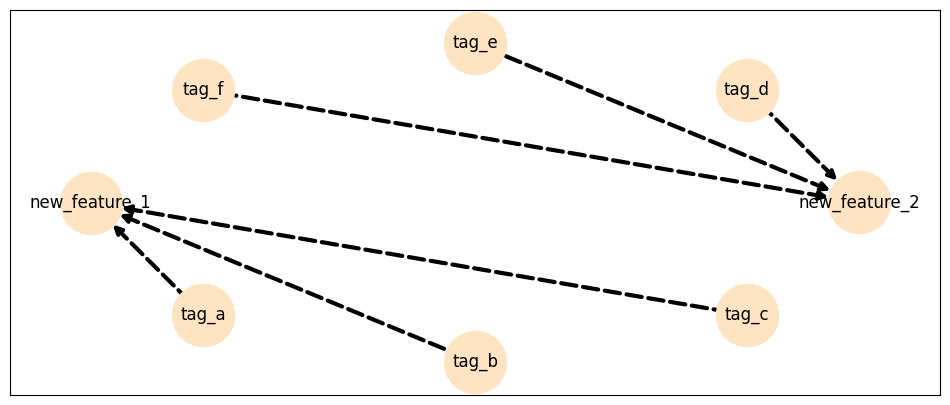

In [3]:
transformer = FeatureFactory(
    {
        "new_feature_1": {
            "dependencies": ["tag_a", "tag_b", "tag_c"],
            "function": "feature_factory.pandas_mean", 
            "kwargs": {"skipna": True},
        },
        "new_feature_2": {
            "dependencies": ["tag_d", "tag_e", "tag_f"],
            "function": "feature_factory.pandas_mean", 
            "kwargs": {"skipna": True},
        }
    }
)
plt.figure(figsize=(12,5))
draw_graph(transformer)

More generally, the `FeatureFactory` expects a dictionary of dictionaries with the following format:

```python
{
    "<new_feature_name>": {
        "dependencies": ["<dependency_1>", "<dependency_2>", ...],
        "function": "<import_path_of_function>,
        "kwargs": {"<key_1>": "<value_1>"},  # Keyword arguments pass to "function" 
    },
    # ... more features ...
}
```

Each of the `<new_feature_name>` features will be created when calling `fit_transform` on a `FeatureFactory` instance. See below for more.

The keys of the feature dictionary are:

- `"dependencies"`: list of columns in the given dataframe or other derived features.
- `"function"`: the string import path of the function to call or a callable. See examples below.
- `"kwargs"`: optional keyword arguments passed to the given function.

If `"function"` is a string, it will be imported and used as a callable. For example:

```python
config = {
    "sum_of_features": {
        "dependencies": ["a", "b", "c"],
        "function": "feature_factory.pandas_sum"
    }
}
```

The following is equivalent to the string based example above:


```python
from feature_factory import pandas_sum
config = {
    "sum_of_features": {
        "dependencies": ["a", "b", "c"],
        "function": pandas_sum
    }
}
```

The `FeatureFactory` class [extends](https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html) the TransformerMixin interface from the sklearn. So calling `fit_transform` will operate as expected. 

We'll use the example dataset below.

In [4]:
transformer = FeatureFactory(
    {
        "sum_iron_silica": {
            "dependencies": ["iron_feed", "silica_feed"],
            "function": "feature_factory.pandas_sum",
            "kwargs": {"skipna": True}
        }
    }
)

transformer.fit_transform(df)[["iron_feed", "silica_feed", "sum_iron_silica"]]

,iron_feed,silica_feed,sum_iron_silica
0,55.200000,16.980000,72.180000
1,55.200000,16.980000,72.180000
2,55.116667,17.120000,72.236667
3,54.950000,17.400000,72.350000
4,54.950000,17.400000,72.350000
...,...,...,...
1468,54.630000,12.900000,67.530000
1469,53.003333,16.333333,69.336667
1470,49.750000,23.200000,72.950000
1471,49.750000,23.200000,72.950000


As expected, a new column `sum_iron_silica` was added and is equal to the sum of `iron_feed` and `silica_feed`.

## Pandas built-ins

The `feature-factory` package includes many basic arithmetic functions when working with dataframes. In the example above, we demonstrated `pandas_sum`. We'll demonstrate a few examples below.

In [5]:
from feature_factory import (
    pandas_mean,
    pandas_prod,
    pandas_sum,
    pandas_max,
    pandas_min,
    pandas_divide,
    pandas_subtract,
    pandas_cut,
    pandas_qcut,
)

Some functions expect only two operands, like division. Of course, this operation is not symmetric. In other words `"dependencies": ["iron_feed", "silica_feed"]` will give a different answer than `"dependencies": ["silica_feed", "iron_feed"]`.

Note that an error will be raised if `len(dependencies) != 2` when using `pandas_divide`.

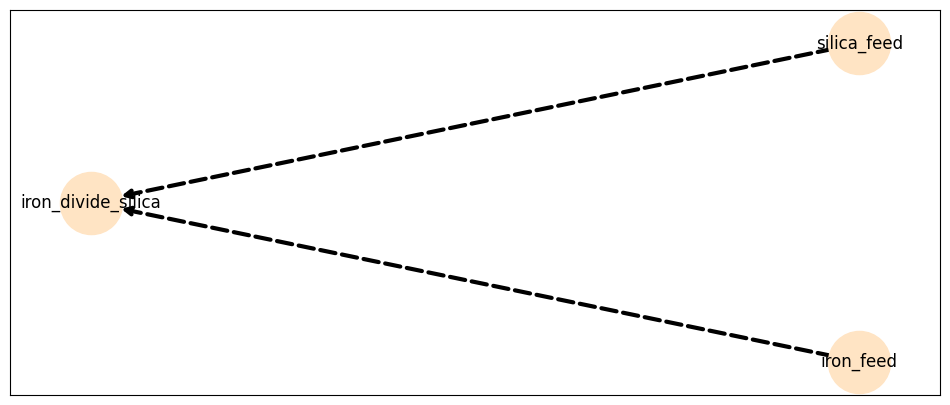

In [6]:
transformer = FeatureFactory(
    {
        "iron_divide_silica": {
            "dependencies": ["iron_feed", "silica_feed"],
            "function": "feature_factory.pandas_divide",
        },
    }
)

plt.figure(figsize=(12,5))
draw_graph(transformer)

In [7]:
transformer.fit_transform(df)[["iron_feed", "silica_feed", "iron_divide_silica"]]

,iron_feed,silica_feed,iron_divide_silica
0,55.200000,16.980000,3.250883
1,55.200000,16.980000,3.250883
2,55.116667,17.120000,3.219431
3,54.950000,17.400000,3.158046
4,54.950000,17.400000,3.158046
...,...,...,...
1468,54.630000,12.900000,4.234884
1469,53.003333,16.333333,3.245102
1470,49.750000,23.200000,2.144397
1471,49.750000,23.200000,2.144397


We can also find the minimum/maximum of a group of columns.

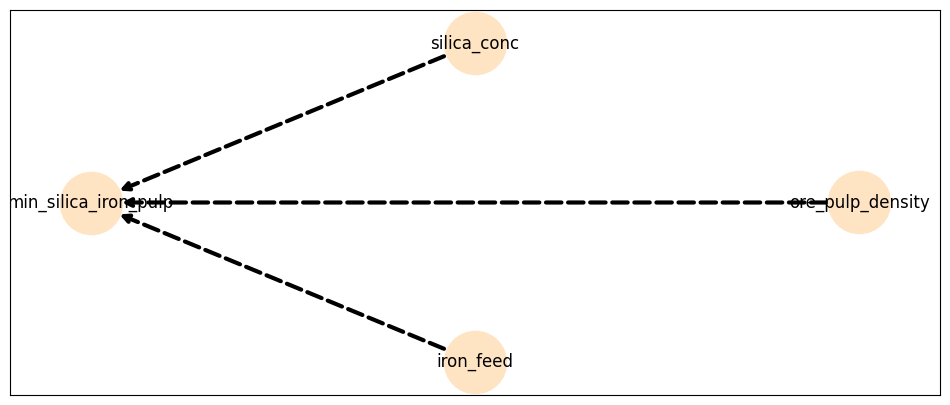

In [8]:
transformer = FeatureFactory(
    {
        "min_silica_iron_pulp": {
            "dependencies": ["iron_feed", "ore_pulp_density", "silica_conc"],
            "function": "feature_factory.pandas_min",
        },
    }
)

plt.figure(figsize=(12,5))
draw_graph(transformer)

In [9]:
transformer.fit_transform(df)[
    ["iron_feed", "ore_pulp_density", "silica_conc", "min_silica_iron_pulp"]
]

,iron_feed,ore_pulp_density,silica_conc,min_silica_iron_pulp
0,55.200000,1.729558,1.310000,1.310000
1,55.200000,1.710517,1.246667,1.246667
2,55.116667,1.765455,1.750000,1.750000
3,54.950000,1.762419,2.063333,1.762419
4,54.950000,1.774991,2.386667,1.774991
...,...,...,...,...
1468,54.630000,1.608842,2.223333,1.608842
1469,53.003333,1.649572,2.563333,1.649572
1470,49.750000,1.659769,2.073333,1.659769
1471,49.750000,1.714762,1.823333,1.714762


Similarly, we can create categorical buckets from existing columns using `pandas_cut` and `pandas_qcut`

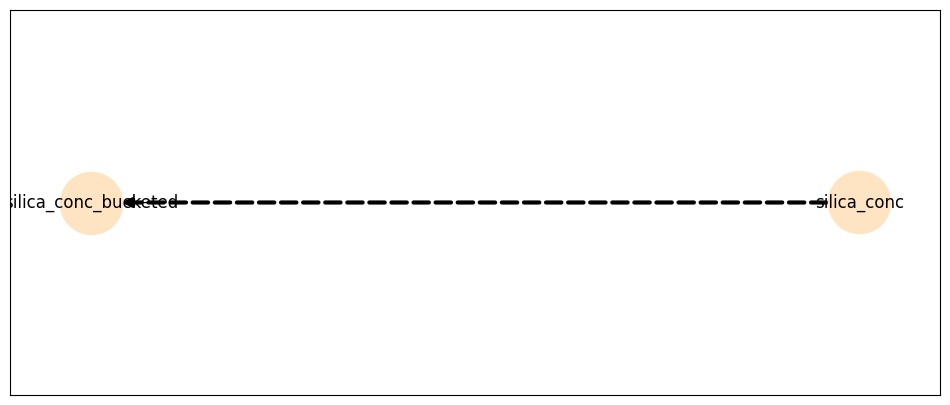

In [10]:
transformer = FeatureFactory(
    {
        "silica_conc_bucketed": {
            "dependencies": ['silica_conc'],
            "function": "feature_factory.pandas_qcut",
            "kwargs": {
                "q": 10,
            }
        },
    }
)

plt.figure(figsize=(12,5))
draw_graph(transformer)

In [11]:
transformer.fit_transform(df)[
    ["silica_conc", "silica_conc_bucketed",]
]

,silica_conc,silica_conc_bucketed
0,1.310000,"(1.24, 1.45]"
1,1.246667,"(1.24, 1.45]"
2,1.750000,"(1.64, 1.83]"
3,2.063333,"(2.045, 2.274]"
4,2.386667,"(2.274, 2.607]"
...,...,...
1468,2.223333,"(2.045, 2.274]"
1469,2.563333,"(2.274, 2.607]"
1470,2.073333,"(2.045, 2.274]"
1471,1.823333,"(1.64, 1.83]"


Other built-in functions operate as expected. Feel free to experiment.

## Custom functions

The `"function"` argument needs to a `Callable` with a signature like `Callable[[pd.DataFrame, Iterable[str], ...], pd.Series]`. Where the `Iterable[str]` should be columns in the given `pd.DataFrame` used to do some calculation and return a `pd.Series`.

See below for an example.

In [12]:
def custom_function(data, dependencies, alpha = 1.0):
    return (
        alpha 
        * data[dependencies[0]] 
        + (data[dependencies[1]] - data[dependencies[2]])
    )

In [13]:
FeatureFactory({
    "custom_feature": {
        "dependencies": ["starch_flow", "amina_flow", "ore_pulp_flow"],
        "function": custom_function,
        "kwargs": {"alpha": 1.25},
    },    
}).fit_transform(df)[["starch_flow", "amina_flow", "ore_pulp_flow", "custom_feature"]]

,starch_flow,amina_flow,ore_pulp_flow,custom_feature
0,3162.625026,578.786678,398.753368,4133.314593
1,3280.258590,574.098837,399.500870,4274.921204
2,3199.440463,619.925237,399.903189,4219.322627
3,3469.331550,590.318354,400.060293,4526.922498
4,4297.453393,540.756644,400.101667,5512.471719
...,...,...,...,...
1468,2844.460325,493.547400,403.534613,3645.588193
1469,2647.281635,496.599240,392.942303,3412.758981
1470,2822.248968,495.229498,380.819898,3642.220809
1471,3408.504232,506.407969,380.874102,4386.164157


## Using derived features in a DAG

We can also use a mix of features that exist in the given dataframe and derived features in our graph definition.

Below, we'll created the following:
- `"flow_sum"`: the sum of two existing features `"starch_flow"`, `"silica_feed"`, and `"pulp_flow"`.
- `"flow_div_feed"`: the quotient of `"flow_sum"` and `"iron_feed"`. 

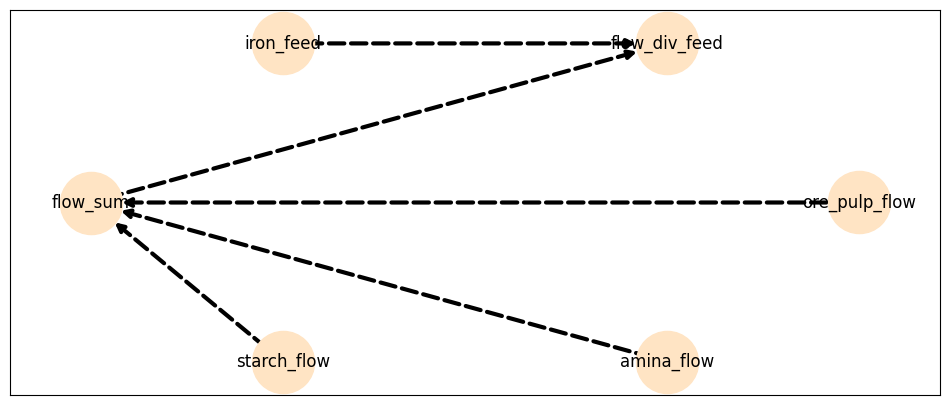

In [14]:
transformer = FeatureFactory(
    {
        "flow_sum": {
            "dependencies": ["starch_flow", "amina_flow", "ore_pulp_flow"],
            "function": "feature_factory.pandas_sum",
        },    
        "flow_div_feed": {
            "dependencies": ["flow_sum", "iron_feed"],
            "function": "feature_factory.pandas_divide",
        },
    }
)

plt.figure(figsize=(12,5))
draw_graph(transformer)

In [15]:
transformer.fit_transform(df)[
    [
        "starch_flow", 
        "amina_flow", 
        "ore_pulp_flow", 
        "flow_sum", 
        "iron_feed", 
        "flow_div_feed"
    ]
]

,starch_flow,amina_flow,ore_pulp_flow,flow_sum,iron_feed,flow_div_feed
0,3162.625026,578.786678,398.753368,4140.165072,55.200000,75.002990
1,3280.258590,574.098837,399.500870,4253.858297,55.200000,77.062650
2,3199.440463,619.925237,399.903189,4219.268889,55.116667,76.551598
3,3469.331550,590.318354,400.060293,4459.710196,54.950000,81.159421
4,4297.453393,540.756644,400.101667,5238.311704,54.950000,95.328693
...,...,...,...,...,...,...
1468,2844.460325,493.547400,403.534613,3741.542337,54.630000,68.488785
1469,2647.281635,496.599240,392.942303,3536.823178,53.003333,66.728316
1470,2822.248968,495.229498,380.819898,3698.298364,49.750000,74.337656
1471,3408.504232,506.407969,380.874102,4295.786303,49.750000,86.347463


## Pickling

The data structures used under the hood in `FeatureFactory` are pickleable. So, any instance is also pickleable.

This means that any `FeatureFactory` instance with any custom functionality might be dumped on disk and then loaded back in memory and used again without retraining.

Below we'll construct, save, and load a simple example.

In [16]:
transformer = FeatureFactory(
    {
        "iron_minus_silica": {
            "dependencies": ["iron_feed", "silica_feed"],
            "function": "feature_factory.pandas_subtract",
        },
    }
)
transformer = transformer.fit(df)

Now we can save the fit transformer and load it back to use it as expected.

In [17]:
import pickle
import tempfile


filename = "sample_feature_factory_transformer.pkl"


with tempfile.TemporaryDirectory() as dirname:
    filepath = Path(dirname) / filename
    with open(filepath, "wb") as fptr:
        pickle.dump(transformer, fptr)
    with open(filepath, "rb") as fptr:
        from_pkl = pickle.load(fptr)

from_pkl.transform(df)[["iron_feed", "silica_feed", "iron_minus_silica"]]

,iron_feed,silica_feed,iron_minus_silica
0,55.200000,16.980000,38.220000
1,55.200000,16.980000,38.220000
2,55.116667,17.120000,37.996667
3,54.950000,17.400000,37.550000
4,54.950000,17.400000,37.550000
...,...,...,...
1468,54.630000,12.900000,41.730000
1469,53.003333,16.333333,36.670000
1470,49.750000,23.200000,26.550000
1471,49.750000,23.200000,26.550000
